# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using TensorBoardLogger
using Logging

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


In [3]:
# TensorBoard
logger = TBLogger("tensorboard_SAC", tb_increment)

TBLogger:
	- Log level     : Info
	- Current step  : 0
	- Output        : /home/larissa/Documents/Projects/ADLR/ADLR_project/src/examples_quadcopter_3D/tensorboard_SAC_1
	- open files    : 1


In [4]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [5]:
Δt = 0.025;

# Create Reinforcement Learning Environment

In [6]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # All possible actions the agent can take
    observation_space::Space{Vector{ClosedInterval{T}}} # All possible states that the agent can observe.
    state::Vector{T} # Current state
    action::ACT # next action the agent wants to apply in the environment.
    done::Bool # shows whether a terminal condition has been reached.
    t::T # time
    rng::R # random number generator

    name::String # for different naming of multible environoments
    visualization::Bool # activate visualisation (Faster computation without visualisation)
    worldtime::Bool # visualization in "real-world" time (only for watching or filming).
    
    # Overall state of the environment. This does not correspond to the observation space of the agent but contains all states that describe the environment.
    x_W::Vector{T} # Position in World frame
    v_B::Vector{T} # Velocity in Body frame
    R_W::Matrix{T} # Rotation (matrix) in World frame
    ω_B::Vector{T} # Rotation velocity in Body frame
    wind_W::Vector{T} # Externel linear velocity acting on the drone
    Δt::T # Time step for physics simulation in seconds
    v_W_target::Vector{T} # Target Velocity in World frame
    
    current_action::Vector{T}
    last_action::Vector{T}
end

In [7]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "Crazyflie",
    visualization = false,
    worldtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    
    # final PWM Values for Crazyflie. The interval definition has no effect in the current implementation.
    action_space = Space(
        ClosedInterval{T}[
            0..1#0..65535, # motor 1
            0..1#0..65535, # motor 2
            0..1#0..65535, # motor 3
            0..1#0..65535, # motor 4
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            typemin(T)..typemax(T), # 1  World Vector UP x
            typemin(T)..typemax(T), # 2  World Vector UP y
            typemin(T)..typemax(T), # 3  World Vector UP z
            typemin(T)..typemax(T), # 4  World Vector FRONT x
            typemin(T)..typemax(T), # 5  World Vector FRONT y
            typemin(T)..typemax(T), # 6  World Vector FRONT z
            
            typemin(T)..typemax(T), # 7  Body target velocity along x
            typemin(T)..typemax(T), # 8  Body target velocity along y
            typemin(T)..typemax(T), # 9  Body target velocity along z
           
            typemin(T)..typemax(T), # 10 Body velocity along x
            typemin(T)..typemax(T), # 11 Body velocity along y
            typemin(T)..typemax(T), # 12 Body velocity along z
            
            typemin(T)..typemax(T), # 13 Body rotational velocity around x
            typemin(T)..typemax(T), # 14 Body rotational velocity around y
            typemin(T)..typemax(T), # 15 Body rotational velocity around z
            ], 
    )
    
    if visualization
        create_Crazyflie(name, actuators = true);
        set_Crazyflie_actuators(name, [0.0; 0.0; 0.0; 0.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,one(QuatRotation));
        set_arrow(string(name, "_vel"), color_vec=[0.0; 1.0; 0.0; 1.0]);
        transform_arrow(string(name, "_vel"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.05)
        set_arrow(string(name, "_vel_current"), color_vec=[1.0; 0.0; 0.0; 1.0]);
        transform_arrow(string(name, "_vel_current"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.02)                  
    end
    


    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        [0.25; 0.25; 0.25; 0.25],#rand(action_space),
        false, # episode done ?
        0.0, # time
        rng, # random number generator  
        name,
        visualization,
        worldtime,
        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        Matrix(one(QuatRotation)), # Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        Δt, # Δt
        zeros(T, 3), # v_W_Target
        [0.25; 0.25; 0.25; 0.25], # current PWM (for reward)
        [0.25; 0.25; 0.25; 0.25], # last PWM (for reward)
    )
    
    
    RLBase.reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

# Define the RL interface

In [8]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [9]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    stay_alive = 10.0
    
    upright_orientation = env.state[3]*10.0 # World Vector UP z (1 = upright)
    Body_velocity = norm(env.v_B .- transpose(env.R_W)*env.v_W_target)*20.0 # Body velocity 
    
    
    thrust_change = norm(env.current_action .- env.last_action)*20.0    
    thrust_balance = std(env.current_action)*40.0

    
    return (stay_alive - Body_velocity-thrust_balance)/80.0
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [10]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    targetVel = [0.0; 0.0; 0.0];
    initialVel = [0.0; 0.0; 0.0];
    
    env.v_W_target = targetVel;
    v_B_target = transpose(env.R_W)*env.v_W_target
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = initialVel;
    env.R_W = Matrix(one(QuatRotation)); # Identity matrix (no rotation)
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
        
 
    env.state = [env.R_W[1,3]; # 1  World Vector UP x
                 env.R_W[2,3]; # 2  World Vector UP y
                 env.R_W[3,3]; # 3  World Vector UP z
                 env.R_W[1,1]; # 4  World Vector FRONT x
                 env.R_W[2,1]; # 5  World Vector FRONT y
                 env.R_W[3,1]; # 6  World Vector FRONT z
                 v_B_target[1]; # 7  Body target velocity along x
                 v_B_target[2]; # 8  Body target velocity along y
                 v_B_target[3]; # 9  Body target velocity along z
                 env.v_B[1]; #  10  Body velocity along x
                 env.v_B[2]; #  11  Body velocity along y
                 env.v_B[3]; #  12  Body velocity along z
                 env.ω_B[1]; #  13  Body rotational velocity around x
                 env.ω_B[2]; #  14  Body rotational velocity around y
                 env.ω_B[3]] #  15  Body rotational velocity around z
    
    env.t = 0.0; # time 0s
    env.action = [0.25; 0.25; 0.25; 0.25] # normalized
    env.last_action = [0.255; 0.255; 0.255; 0.255] # normalized
    env.current_action = [0.255; 0.255; 0.255; 0.255] # normalized

    env.done = false # reset termination
    
    if env.visualization
        # Visualize initial state
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
        transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05) 
        transform_arrow(string(env.name, "_vel_current"), env.x_W, [0.0; 0.0; 0.0], max_head_radius=0.05) 
    end
    
    nothing # return nothing
end;

In [11]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)


    # call the step on the environoment with the next action 
    _step!(env, a)
        
end

In [12]:
env = VtolEnv();

In [13]:
function scale_actions(next_action)
    return next_action*22000.0
end

scale_actions (generic function with 1 method)

In [14]:
function _step!(env::VtolEnv, next_action)
    

    env.last_action = copy(env.current_action)
    env.current_action[1] = next_action[1]
    env.current_action[2] = next_action[2]
    env.current_action[3] = next_action[3]
    env.current_action[4] = next_action[4]
    
    
    
    scaled_actions = scale_actions.(next_action) # between 0 and 1 for neual network
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = crazyflie_model(scaled_actions);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, _, env.R_W, env.ω_B, _, env.t = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, crazyflie_param)

    
    if env.visualization
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, next_action[1:4])
        transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05)               
        transform_arrow(string(env.name, "_vel_current"), env.x_W, env.R_W*env.v_B, max_head_radius=0.05) 
    end
    
    if env.worldtime
        sleep(env.Δt)
    end
    
    v_B_target = transpose(env.R_W)*env.v_W_target
    
    
    # State space
    env.state = [env.R_W[1,3]; # 1  World Vector UP x
                 env.R_W[2,3]; # 2  World Vector UP y
                 env.R_W[3,3]; # 3  World Vector UP z
                 env.R_W[1,1]; # 4  World Vector FRONT x
                 env.R_W[2,1]; # 5  World Vector FRONT y
                 env.R_W[3,1]; # 6  World Vector FRONT z
                 v_B_target[1]; # 7  Body target velocity along x
                 v_B_target[2]; # 8  Body target velocity along y
                 v_B_target[3]; # 9  Body target velocity along z
                 env.v_B[1]; # 10  Body velocity along x
                 env.v_B[2]; # 11  Body velocity along y
                 env.v_B[3]; # 12  Body velocity along z
                 env.ω_B[1]; # 13 Body rotational velocity around x
                 env.ω_B[2]; # 14 Body rotational velocity around y
                 env.ω_B[3]] # 15 Body rotational velocity around z
    

    
    
    # Termination criteria
    env.done =
        norm(env.v_B) > 20.0 || # m/sec stop if body is to fast
        norm(env.ω_B) > 40.0 || # rad/sec stop if body rotatesto fast
        env.R_W[3,3] < 0.7 || # Stop if the drone is pitched/rolled to muche
        env.t > 4.0 # stop after 10s
        
    nothing
end;

In [15]:
RLBase.test_runnable!(env)

random policy with VtolEnv: Error During Test at /home/larissa/.julia/packages/ReinforcementLearningBase/E7jI5/src/base.jl:266
  Got exception outside of a @test
  BoundsError: attempt to access Tuple{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Float64} at index [6]
  Stacktrace:
    [1] indexed_iterate
      @ ./tuple.jl:88 [inlined]
    [2] _step!(env::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, Random._GLOBAL_RNG}, next_action::Vector{Float64})
      @ Main ./In[14]:18
    [3] (::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, Random._GLOBAL_RNG})(a::Vector{Float64})
      @ Main ./In[11]:7
    [4] macro expansion
      @ ~/.julia/packages/ReinforcementLearningBase/E7jI5/src/base.jl:281 [inlined]
    [5] macro expansion
      @ /opt/julia-1.8.0/share/julia/stdlib/v1.8/Test/src/Test.jl:1357 [inlined]
    [6] test_runnable!(env::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, Rand

LoadError: [91mSome tests did not pass: 2 passed, 0 failed, 1 errored, 0 broken.[39m

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [16]:
seed = 123    
rng = StableRNG(seed)
UPDATE_FREQ = 2048
EVALUATION_FREQ = 1_000_000
SAVE_FREQ = 10_000_000

env = VtolEnv(; rng = StableRNG(hash(seed)), name = "cf_SAC")


# VtolEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[-Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf])`

## Action Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[0.0..1.0, 0.0..1.0, 0.0..1.0, 0.0..1.0])`

## Current State

```
[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```


In [17]:
# Define the function approximator
    ns, na = length(state(env)), length(action_space(env))

create_policy_net() = NeuralNetworkApproximator(
        model = GaussianNetwork(
            pre = Chain(
                Dense(ns, 64, relu, init = glorot_uniform(rng)),
                Dense(64, 64, relu, init = glorot_uniform(rng)),
            ),
            μ = Chain(Dense(64, na, init = glorot_uniform(rng))),
            logσ = Chain(Dense(64, na, x -> clamp.(x, typeof(x)(-10), typeof(x)(2)), init = glorot_uniform(rng))),
        ),
        optimizer = ADAM(1e-4),
    )

    create_q_net() = NeuralNetworkApproximator(
        model = Chain(
            Dense(ns + na, 64, relu; init = glorot_uniform(rng)),
            Dense(64, 64, relu; init = glorot_uniform(rng)),
            Dense(64, 1; init = glorot_uniform(rng)),
        ),
        optimizer = ADAM(1e-4),
    )

create_q_net (generic function with 1 method)

In [18]:
dataset_size = 100_000_000
start_steps = dataset_size
trajectory_num = dataset_size

100000000

In [19]:
    agent = Agent( # A wrapper of an AbstractPolicy
         
    
    policy = SACPolicy(
            policy = create_policy_net(),
            qnetwork1 = create_q_net(),
            qnetwork2 = create_q_net(),
            #target_qnetwork1 = create_q_net(),
            #target_qnetwork2 = create_q_net(),
            γ = 0.99f0,
            τ = 0.005f0,
            α = 0.2f0,
            batch_size = 256,
            start_steps = start_steps,
            start_policy = RandomPolicy(Space([-1.0..1.0 for _ in 1:na]); rng = rng),
            update_after = start_steps,
            update_freq = UPDATE_FREQ,
            automatic_entropy_tuning = true,
            lr_alpha = 0.003f0,
            action_dims = na,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = dataset_size+1,
            state = Vector{Float32} => (ns,),
            action = Vector{Float32} => (na,),
        ),

    
    );






In [20]:
function saveModel(t, agent, env)
    model = cpu(agent.policy)   
    f = joinpath("./", "cf_sac_$t.bson")
    @save f model
    println("parameters at step $t saved to $f")
end

saveModel (generic function with 1 method)

In [21]:
function validate_policy(t, agent, env)
    # for validation extract the policy from the agend
    run(agent.policy, test_env, StopAfterEpisode(1), 
        ComposedHook(
        episode_test_step_hook, 
        episode_test_reward_hook
    ),
        )
    # the result of the hook
    reward = round((episode_test_reward_hook.rewards[end]),digits = 3)
    length = episode_test_step_hook.steps[end-1]
    
    println("step: ", t, " reward : ",reward, " length: ", length)

    with_logger(logger) do
        @info "evaluating" avg_length = length  avg_reward = reward  log_step_increment = 0
    end
    end;

episode_test_reward_hook = TotalRewardPerEpisode( is_display_on_exit=false)
episode_test_step_hook = StepsPerEpisode()
# create a env only for reward test

test_env = VtolEnv(;name = "test_cf", visualization = true, worldtime = true);

In [22]:
# Define hook which is called during the training
total_reward_per_episode = TotalRewardPerEpisode(is_display_on_exit = false)
hook = ComposedHook(
    #total_batch_reward_per_episode,
    #DoEveryNStep(saveModel, n=SAVE_FREQ),
    DoEveryNStep(validate_policy, n=EVALUATION_FREQ),
    #=
    DoEveryNStep() do t, agent, env
        p = agent.policy
        with_logger(logger) do
            @info "training" loss = mean(p.loss)  actor_loss = mean(p.actor_loss)  critic_loss = mean(p.critic_loss)
        end
    end,
    =#
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            if length(total_reward_per_episode.rewards) > 1
                @info "training" total_reward_per_episode.rewards[end]
            end
        end
    end,
    #=
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            @info "training" action_thrust_1 = env[1].action[1]  action_thrust_2 = env[1].action[2] action_thrust_3 = env[1].action[3] action_thrust_4 = env[1].action[4]
        end
    end,
    =#
);

In [23]:
run(agent,
    env,
    StopAfterStep(100_000_000_000),
    hook
)

LoadError: BoundsError: attempt to access Tuple{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Float64} at index [6]

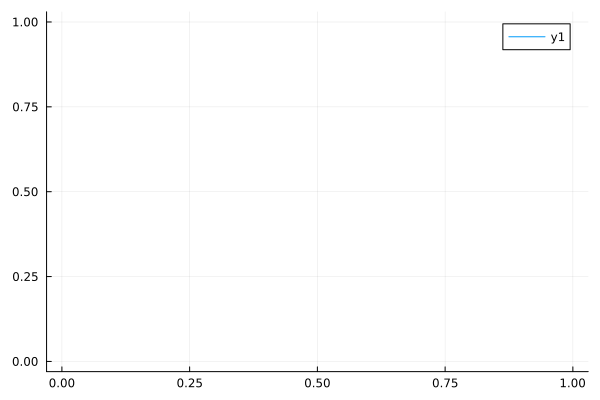

In [24]:
plot(episode_test_reward_hook.rewards)

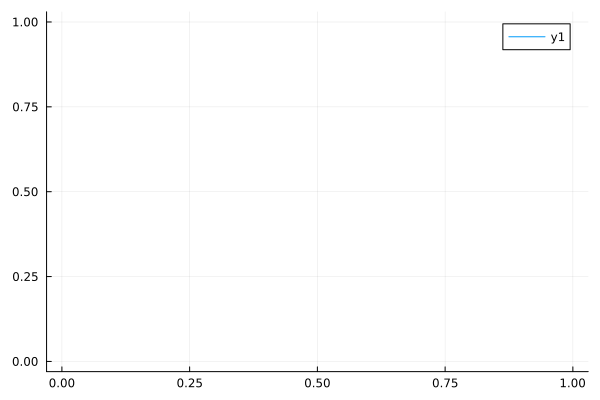

In [25]:
plot(episode_test_step_hook.steps[1:2:end])